In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.preprocessing import scale
from scipy.signal import savgol_filter
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [2]:
def remove_noise(frame, first_par, second_par):
    w_out_noise = savgol_filter(frame["StockValue"], first_par, second_par,
                                #mode='constant'
                               )
    frame["StockValue"] = w_out_noise
    frame_f = frame[["StockValue"]]
    return frame_f

In [3]:
def ma_columns(frame_column, list_ma):
    MAs = [] 
    for ma in list_ma:
        MA = pd.DataFrame(sm.short_moving_average(frame_column, ma)["StockValue"]).rename(columns={"StockValue": f"MA_{ma}"})
        MAs.append(MA)
        
    frame = MAs[0].join(MAs[1])
    for i in range(len(MAs)-2):
        frame = frame.join(MAs[i+2])
    
    frame = frame.dropna()
    
    return frame

In [4]:
def buy_sell_recommendations(new_frame):
    new_frame['rec_1'] = np.where(((new_frame['MA_7_50']>=0) & (new_frame['MA_7_50']*1 > new_frame["MA_50_200"]*0.8))
                                  | ((new_frame['MA_7_50']<0) & (new_frame['MA_7_50']*1 > new_frame["MA_50_200"]*0.8))
                                         ,"BUY", "SELL")
    
    new_frame['rec_2'] = np.where(((new_frame['MA_14_100']>=0) & (new_frame['MA_14_100']*1 > new_frame["MA_50_200"]*0.8))
                              | ((new_frame['MA_14_100']<0) & (new_frame['MA_14_100']*1 > new_frame["MA_50_200"]*0.8))
                                     ,"BUY", "SELL")
    
    return new_frame

In [5]:
def get_locations(new_frame):
    loc_first=[]
    for row in range(new_frame.shape[0]-1):

            if new_frame.iloc[row,:].rec_1 == "SELL":
                if new_frame.iloc[row+1,:].rec_1 == "BUY":
                    start = row+1
                    loc_first.append(start)

            if new_frame.iloc[row,:].rec_1 == "BUY":
                if new_frame.iloc[row+1,:].rec_1 == "SELL":
                    end = row+2
                    loc_first.append(end)
                    
    loc_second=[]
    for row in range(new_frame.shape[0]-1):

        if new_frame.iloc[row,:].rec_2 == "SELL":
            if new_frame.iloc[row+1,:].rec_2 == "BUY":
                start = row+1
                loc_second.append(start)

        if new_frame.iloc[row,:].rec_2 == "BUY":
            if new_frame.iloc[row+1,:].rec_2 == "SELL":
                end = row+2
                loc_second.append(end)
                
    return [loc_first, loc_second]

In [6]:
def get_transactions(new_frame, column, locations):
    if new_frame.iloc[0,:][str(column)] == "SELL":
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(0,len(locations),2), range(1,len(locations),2))]
    else:
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(1,len(locations),2), range(2,len(locations),2))]
        transactions.insert(0, [0, locations[0]])

    return transactions

In [7]:
def returns(new_frame, list_of_transactions):
    returns = []
    for transactions in list_of_transactions:
        buy = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[0]
        sell = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[-1]
        ret = (sell-buy)/buy
        returns.append(ret)
    
    return returns

In [8]:
def prod(list_of_all_returns):
    return np.prod([ret+1 for ret in list_of_all_returns]) 

In [9]:
def get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [10]:
def simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    loc_first = get_locations(new_frame)[0]
    loc_second = get_locations(new_frame)[1]
    
    first_transactions = get_transactions(new_frame, "rec_1", loc_first)
    second_transactions = get_transactions(new_frame, "rec_2", loc_second)

    first_returns = returns(new_frame, first_transactions)
    second_returns = returns(new_frame, second_transactions)
    
    first_cum_return = prod(first_returns)
    print(f"Final position of first transactions : {first_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in first_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of first transactions        : {[round(first,3) for first in first_returns]}")
    print(f"Locations of first transactions      : {first_transactions}")
    print("-"*85)
    
    second_cum_return  = prod(second_returns)
    print(f"Final position of second transactions: {second_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in second_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of second transactions       : {[round(second,3) for second in second_returns]}")
    print(f"Locations of second transactions     : {second_transactions}")
    print("-"*85)

    totalReturn = (first_cum_return + second_cum_return) / 2
    print(f"Ultimate position : {totalReturn}")
    
    return totalReturn

In [577]:
start_date = "01-12-2014"
end_date = "12-03-2020"
stock_name = "KORDS"
ma_list=[7,14,50,100,200]
noise_first_par = 51
noise_second_par = 2

In [578]:
simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par)

Final position of first transactions : 3.8195300065603908
Duration (days) - total length       : 451 - 1132
Returns of first transactions        : [0.22, 0.264, 0.138, 0.015, 0.044, 0.548, 0.134, 0.169]
Locations of first transactions      : [[0, 108], [145, 176], [323, 369], [400, 413], [529, 617], [710, 779], [869, 909], [1061, 1117]]
-------------------------------------------------------------------------------------
Final position of second transactions: 3.531454797267546
Duration (days) - total length       : 582 - 1132
Returns of second transactions       : [0.216, 0.174, -0.019, 0.269, 0.071, 0.48, 0.185, 0.057]
Locations of second transactions     : [[7, 116], [143, 190], [224, 243], [336, 439], [566, 658], [719, 801], [879, 947], [1064, 1126]]
-------------------------------------------------------------------------------------
Ultimate position : 3.675492401913968


3.675492401913968

In [ ]:
frame = get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par)

In [580]:
frame.iloc[:,:]

,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,Date,StockValue,rec_1,rec_2
199,3.104087,3.099904,3.367267,3.610898,3.768048,-0.263180,-0.510994,-0.400781,2015-09-11,3.0789,BUY,SELL
200,3.112391,3.102876,3.356094,3.596949,3.769145,-0.243703,-0.494073,-0.413051,2015-09-14,3.1360,BUY,SELL
201,3.122192,3.106823,3.345084,3.583227,3.770151,-0.222892,-0.476404,-0.425066,2015-09-15,3.2095,BUY,SELL
202,3.133777,3.112039,3.334389,3.569897,3.771093,-0.200611,-0.457858,-0.436704,2015-09-16,3.2912,BUY,SELL
203,3.146943,3.118860,3.323965,3.556959,3.771973,-0.177022,-0.438099,-0.448008,2015-09-17,3.4219,BUY,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...
1326,12.829992,13.338510,13.509202,12.563412,12.139833,-0.679210,0.775098,1.369369,2020-03-06,12.4825,SELL,SELL
1327,12.645635,13.188336,13.499164,12.569093,12.140726,-0.853529,0.619243,1.358439,2020-03-09,11.3743,SELL,SELL
1328,12.451512,13.028395,13.483735,12.572830,12.140455,-1.032223,0.455565,1.343279,2020-03-10,10.9368,SELL,SELL
1329,12.247622,12.858688,13.462899,12.574600,12.138965,-1.215277,0.284089,1.323934,2020-03-11,10.7910,SELL,SELL


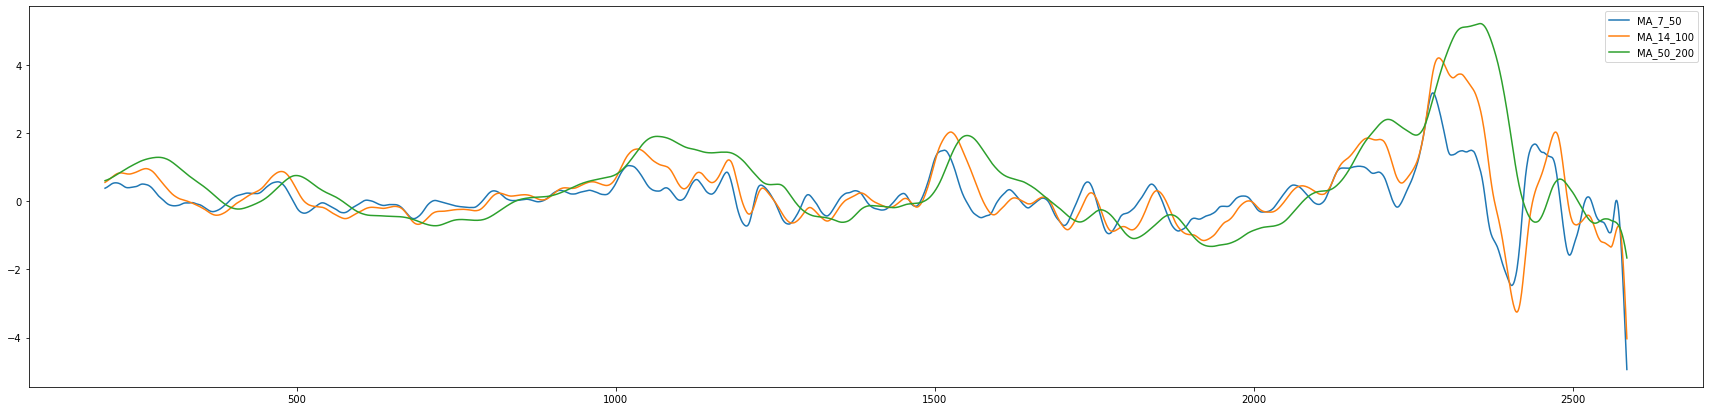

In [568]:
frame[["MA_7_50","MA_14_100","MA_50_200"]].plot(figsize=(30,7))

In [361]:
sm.volatility(stock_name, start_date, end_date)

0.025020052317953893

---

In [136]:
start_date = "01-03-2015"
end_date = "25-02-2021"
ma_list=[7,14,50,100,200]
noise_first_par = 81
noise_second_par = 2

In [137]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [138]:
results = [] 
for stock_name in BIST50:
    print(stock_name)
    frame = simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par)
    results.append(frame)
    print("*"*100)

TUPRS
Final position of first transactions : 2.557788689229091
Duration (days) - total length       : 451 - 1141
Returns of first transactions        : [0.115, 0.342, 0.014, 0.333, 0.134, 0.202, -0.072]
Locations of first transactions      : [[45, 90], [150, 297], [563, 612], [618, 712], [782, 821], [895, 940], [1006, 1038]]
-------------------------------------------------------------------------------------
Final position of second transactions: 2.0393451859453595
Duration (days) - total length       : 407 - 1141
Returns of second transactions       : [0.048, 0.554, 0.178, 0.055, 0.007]
Locations of second transactions     : [[58, 102], [197, 322], [575, 726], [794, 837], [910, 954]]
-------------------------------------------------------------------------------------
Ultimate position : 2.2985669375872253
****************************************************************************************************
VAKBN
Final position of first transactions : 3.7452850994259017
Duration (days)

Final position of first transactions : 2.4128296097630995
Duration (days) - total length       : 473 - 1141
Returns of first transactions        : [0.012, 0.222, -0.005, 0.162, 0.171, 0.057, 0.136, 0.199]
Locations of first transactions      : [[0, 9], [20, 98], [165, 208], [265, 323], [512, 557], [636, 801], [880, 922], [997, 1030]]
-------------------------------------------------------------------------------------
Final position of second transactions: 2.6675463634882637
Duration (days) - total length       : 514 - 1141
Returns of second transactions       : [0.049, 0.042, 0.258, 0.067, 0.461, 0.077, 0.155]
Locations of second transactions     : [[0, 110], [188, 220], [273, 367], [519, 570], [686, 815], [889, 941], [1000, 1046]]
-------------------------------------------------------------------------------------
Ultimate position : 2.5401879866256816
****************************************************************************************************
KOZAA
Final position of first t

Final position of first transactions : 1.985471834071723
Duration (days) - total length       : 532 - 1141
Returns of first transactions        : [0.255, 0.058, 0.063, -0.06, 0.07, 0.137, 0.229]
Locations of first transactions      : [[0, 88], [188, 324], [517, 569], [636, 659], [668, 831], [885, 914], [1005, 1046]]
-------------------------------------------------------------------------------------
Final position of second transactions: 2.310782742765901
Duration (days) - total length       : 543 - 1141
Returns of second transactions       : [0.189, 0.005, 0.406, 0.025, 0.257, 0.017, 0.049]
Locations of second transactions     : [[0, 107], [202, 221], [244, 380], [525, 580], [697, 846], [890, 925], [1014, 1056]]
-------------------------------------------------------------------------------------
Ultimate position : 2.148127288418812
****************************************************************************************************
SODA
Final position of first transactions : 3.33640

Final position of first transactions : 2.036950736742572
Duration (days) - total length       : 538 - 1141
Returns of first transactions        : [0.259, 0.039, 0.07, 0.114, 0.116, 0.17]
Locations of first transactions      : [[30, 75], [260, 302], [335, 370], [490, 809], [883, 911], [956, 1025]]
-------------------------------------------------------------------------------------
Final position of second transactions: 1.9770042155716192
Duration (days) - total length       : 567 - 1141
Returns of second transactions       : [0.157, 0.393, -0.218, 0.514, -0.109, 0.163]
Locations of second transactions     : [[35, 96], [271, 400], [509, 641], [677, 821], [898, 913], [959, 1045]]
-------------------------------------------------------------------------------------
Ultimate position : 2.0069774761570955
****************************************************************************************************
YATAS
Final position of first transactions : 2.6619819876999293
Duration (days) - total

Final position of first transactions : 3.3691231763795346
Duration (days) - total length       : 306 - 1141
Returns of first transactions        : [0.384, 0.405, 0.239, 0.146, 0.22]
Locations of first transactions      : [[71, 121], [274, 367], [550, 584], [730, 826], [984, 1017]]
-------------------------------------------------------------------------------------
Final position of second transactions: 9.615756832211433
Duration (days) - total length       : 544 - 1141
Returns of second transactions       : [0.02, 0.276, 1.289, 0.151, 0.28, 0.108, 0.777, 0.113]
Locations of second transactions     : [[0, 12], [77, 141], [282, 467], [554, 603], [752, 849], [897, 936], [977, 1053], [1106, 1128]]
-------------------------------------------------------------------------------------
Ultimate position : 6.492440004295484
****************************************************************************************************
PGSUS
Final position of first transactions : 3.391747416464221
Duration

Final position of first transactions : 2.5981623136720424
Duration (days) - total length       : 503 - 1141
Returns of first transactions        : [0.204, -0.009, 0.282, 0.305, 0.048, 0.242]
Locations of first transactions      : [[44, 97], [186, 195], [258, 385], [500, 558], [643, 820], [948, 1027]]
-------------------------------------------------------------------------------------
Final position of second transactions: 2.576139288577001
Duration (days) - total length       : 491 - 1141
Returns of second transactions       : [0.043, 0.105, 0.278, 0.16, 0.279, 0.179]
Locations of second transactions     : [[0, 2], [57, 116], [276, 401], [510, 573], [682, 836], [957, 1045]]
-------------------------------------------------------------------------------------
Ultimate position : 2.5871508011245217
****************************************************************************************************
CCOLA
Final position of first transactions : 3.9547554604114397
Duration (days) - total le

In [139]:
sum(results) / len(results)

4.154359531255278

In [140]:
df = pd.DataFrame(list(zip(BIST50, results)), 
               columns =['Name', 'result'])

In [141]:
df.to_pickle("First_81_2")

In [144]:
first = pd.read_pickle("First_41_2")

In [145]:
second = pd.read_pickle("First_51_2")

In [146]:
third = pd.read_pickle("First_61_2")

In [147]:
fourth = pd.read_pickle("First_71_2")

In [152]:
fifth = pd.read_pickle("First_81_2")

In [153]:
sixth = pd.read_pickle("First_91_2")

In [163]:
seventh = pd.read_pickle("First_101_2")

In [155]:
frame = pd.concat([first, second, third, fourth, fifth, sixth, seventh], axis=1)

In [156]:
first["result"].sum()

177.18852128901577

In [157]:
second["result"].sum()

190.17052028253272

In [158]:
third["result"].sum()

205.03584568146357

In [159]:
fourth["result"].sum()

209.0407971537972

In [160]:
fifth["result"].sum()

207.717976562764

In [161]:
sixth["result"].sum()

209.54342197787582

In [165]:
seventh["result"].sum()

177.18852128901577

In [166]:
frame

,Name,result,Name,result,Name,result,Name,result,Name,result,Name,result,Name,result
0,TUPRS,1.734089,TUPRS,1.884215,TUPRS,2.128079,TUPRS,2.212120,TUPRS,2.298567,TUPRS,2.385186,TUPRS,1.734089
1,VAKBN,2.972863,VAKBN,3.138573,VAKBN,3.183075,VAKBN,3.452778,VAKBN,3.202051,VAKBN,3.267126,VAKBN,2.972863
2,TOASO,1.465232,TOASO,1.461326,TOASO,1.442691,TOASO,1.517630,TOASO,1.642621,TOASO,1.656872,TOASO,1.465232
3,KRDMD,2.619413,KRDMD,2.653084,KRDMD,2.802094,KRDMD,3.145934,KRDMD,2.919268,KRDMD,3.432969,KRDMD,2.619413
4,MGROS,1.425316,MGROS,1.613297,MGROS,1.551981,MGROS,1.550892,MGROS,1.673059,MGROS,1.483873,MGROS,1.425316
5,DOHOL,5.210196,DOHOL,5.126607,DOHOL,5.408344,DOHOL,4.893426,DOHOL,5.267192,DOHOL,5.451786,DOHOL,5.210196
6,AKBNK,1.943533,AKBNK,1.958986,AKBNK,2.027669,AKBNK,2.039224,AKBNK,2.077696,AKBNK,2.079192,AKBNK,1.943533
7,TKFEN,3.648816,TKFEN,3.701214,TKFEN,3.875354,TKFEN,3.961298,TKFEN,3.720208,TKFEN,3.284134,TKFEN,3.648816
8,FROTO,1.735844,FROTO,1.723818,FROTO,1.885795,FROTO,1.828227,FROTO,1.946651,FROTO,1.910910,FROTO,1.735844
9,GARAN,2.337127,GARAN,2.402540,GARAN,2.554026,GARAN,2.543963,GARAN,2.540188,GARAN,2.512596,GARAN,2.337127


In [ ]:
## Fonksiyonların nasıl çalıştığını hatırlamak için aşağıda yer alan tutorial incele!

---
### TUTORIAL 

In [296]:
start_date = "01-03-2015"
end_date = "18-04-2020"
stock_name = "BIMAS"
ma_list=[7,14,50,100,200]
noise_first_par = 51
noise_second_par = 2

In [297]:
# scrap et getir --> ihtiyaç hisse senedi değerleri (günlük)
frame = sm.extract_stock_values(start_date, end_date, [stock_name])
frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
frame.to_pickle(stock_name)

In [298]:
frame

,HGDG_HS_KODU,HGDG_TARIH,StockValue,HGDG_AOF,HGDG_MIN,HGDG_MAX,HGDG_HACIM,END_ENDEKS_KODU,END_TARIH,END_SEANS,...,HG_MIN,HG_MAX,PD,PD_USD,HAO_PD,HAO_PD_USD,HG_HACIM,DOLAR_BAZLI_MIN,DOLAR_BAZLI_MAX,DOLAR_BAZLI_AOF
1,BIMAS,2015-03-02,20.5730,20.479206,20.332272,20.660563,37486761.0,01,1425243600000,2,...,46.60,47.05,1.426920e+10,5.670256e+09,8.561520e+09,3.402154e+09,15766418.0,8.0796,8.2100,8.1380
3,BIMAS,2015-03-03,20.7700,20.579740,20.463590,20.769999,38492868.0,01,1425330000000,2,...,46.75,47.45,1.440582e+10,5.709345e+09,8.643492e+09,3.425607e+09,7039384.0,8.1102,8.2316,8.1562
5,BIMAS,2015-03-04,19.2161,19.352947,18.712694,20.463590,214939983.0,01,1425416400000,2,...,42.75,45.00,1.332804e+10,5.235922e+09,7.996824e+09,3.141553e+09,67991604.0,7.3513,8.0391,7.6028
7,BIMAS,2015-03-05,19.0410,19.184834,18.887785,19.588142,72683059.0,01,1425502800000,2,...,43.25,43.90,1.320660e+10,5.106566e+09,7.923960e+09,3.063939e+09,31364107.0,7.3033,7.5741,7.4182
9,BIMAS,2015-03-06,20.0478,19.725624,19.347395,20.069641,143322554.0,01,1425589200000,2,...,44.60,45.85,1.390488e+10,5.342483e+09,8.342928e+09,3.205490e+09,52421874.0,7.4336,7.7111,7.5789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,BIMAS,2020-04-13,51.0519,51.409443,51.051930,51.745167,105596314.0,01,1586725200000,2,...,51.55,52.25,3.130116e+10,4.620779e+09,2.123784e+10,3.135199e+09,105596314.0,7.5365,7.6388,7.5892
1479,BIMAS,2020-04-14,51.3490,51.202460,50.754830,51.794685,153389798.0,01,1586811600000,2,...,51.25,52.30,3.148332e+10,4.638495e+09,2.136143e+10,3.147219e+09,153389798.0,7.4778,7.6310,7.5438
1480,BIMAS,2020-04-15,53.6268,52.627560,50.160630,54.468597,538905843.0,01,1586898000000,2,...,50.65,55.00,3.287988e+10,4.791030e+09,2.230242e+10,3.249756e+09,538905843.0,7.3091,7.9368,7.6685
1481,BIMAS,2020-04-16,54.0725,54.435917,53.478260,55.359905,293496463.0,01,1586984400000,2,...,54.00,55.90,3.315312e+10,4.791121e+09,2.248776e+10,3.249817e+09,293496463.0,7.7284,8.0003,7.8668


In [299]:
# noise temizleme --> yöntem ve parametreler için fonksiyonunun detayına bak
frame = remove_noise(frame, 51, 2)
frame

,StockValue
1,19.249365
3,19.332501
5,19.414292
7,19.494738
9,19.573839
...,...
1478,51.756918
1479,51.859606
1480,51.962127
1481,52.064481


In [45]:
# gürültüsü temizlenmiş hisse senedi verilerinden hareketli ortalamaları hesapla
new_frame = ma_columns(frame, [7,14,50,100,200])
new_frame

,MA_7,MA_14,MA_50,MA_100,MA_200
399,25.323111,25.077697,23.354192,22.273889,21.737592
401,25.373402,25.145479,23.436513,22.313144,21.751858
403,25.418949,25.208420,23.518590,22.352933,21.766690
405,25.461215,25.267719,23.600299,22.393265,21.782105
407,25.500372,25.322419,23.681516,22.434161,21.798072
...,...,...,...,...,...
1605,66.896079,65.273981,58.537089,53.796821,50.000068
1606,67.384433,65.740550,58.891442,54.006278,50.108098
1607,67.879011,66.213343,59.252583,54.219965,50.218616
1608,68.379814,66.692360,59.619899,54.437992,50.331697


In [46]:
# belirli haretketli ortalamalar arasındaki farkı al
new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]

In [47]:
# iki koldan işlem yapılacak. Detayı için buy_sell_recommendation fonskiyonuna bak
new_frame = buy_sell_recommendations(new_frame)
new_frame

,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,rec_1,rec_2
399,25.323111,25.077697,23.354192,22.273889,21.737592,1.968919,2.803807,1.616600,BUY,BUY
401,25.373402,25.145479,23.436513,22.313144,21.751858,1.936890,2.832335,1.684654,BUY,BUY
403,25.418949,25.208420,23.518590,22.352933,21.766690,1.900359,2.855488,1.751900,BUY,BUY
405,25.461215,25.267719,23.600299,22.393265,21.782105,1.860915,2.874454,1.818194,BUY,BUY
407,25.500372,25.322419,23.681516,22.434161,21.798072,1.818856,2.888258,1.883444,SELL,BUY
...,...,...,...,...,...,...,...,...,...,...
1605,66.896079,65.273981,58.537089,53.796821,50.000068,8.358990,11.477160,8.537021,SELL,BUY
1606,67.384433,65.740550,58.891442,54.006278,50.108098,8.492991,11.734272,8.783344,SELL,BUY
1607,67.879011,66.213343,59.252583,54.219965,50.218616,8.626428,11.993378,9.033967,SELL,BUY
1608,68.379814,66.692360,59.619899,54.437992,50.331697,8.759915,12.254368,9.288202,SELL,BUY


In [48]:
# başta scrap edilen ve ham hali hisse senedinin adı ile pickle olarak kaydedilen hisse değerlerini tekrar çağır
#   ve yeni oluşturulan frame ile birleştir.
frame = pd.read_pickle(stock_name)
frame = frame[["HGDG_TARIH", "StockValue"]]
new_frame = new_frame.join(frame)
new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
new_frame

,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,rec_1,rec_2,HGDG_TARIH,StockValue
399,25.323111,25.077697,23.354192,22.273889,21.737592,1.968919,2.803807,1.616600,BUY,BUY,2015-10-16,25.8411
401,25.373402,25.145479,23.436513,22.313144,21.751858,1.936890,2.832335,1.684654,BUY,BUY,2015-10-19,26.2611
403,25.418949,25.208420,23.518590,22.352933,21.766690,1.900359,2.855488,1.751900,BUY,BUY,2015-10-20,26.4600
405,25.461215,25.267719,23.600299,22.393265,21.782105,1.860915,2.874454,1.818194,BUY,BUY,2015-10-21,25.9704
407,25.500372,25.322419,23.681516,22.434161,21.798072,1.818856,2.888258,1.883444,SELL,BUY,2015-10-22,26.1707
...,...,...,...,...,...,...,...,...,...,...,...,...
1605,66.896079,65.273981,58.537089,53.796821,50.000068,8.358990,11.477160,8.537021,SELL,BUY,2020-06-22,68.6500
1606,67.384433,65.740550,58.891442,54.006278,50.108098,8.492991,11.734272,8.783344,SELL,BUY,2020-06-23,69.0000
1607,67.879011,66.213343,59.252583,54.219965,50.218616,8.626428,11.993378,9.033967,SELL,BUY,2020-06-24,70.9500
1608,68.379814,66.692360,59.619899,54.437992,50.331697,8.759915,12.254368,9.288202,SELL,BUY,2020-06-25,70.1500


In [55]:
# Stratejilere göre işlem yapılan tarih aralıkları
loc_first = get_locations(new_frame)[0]
loc_second = get_locations(new_frame)[1]

In [56]:
loc_first

[5, 85, 133, 242, 369, 652, 765, 909, 978, 1139, 1175]

In [57]:
loc_second

[20, 98, 150, 261, 411, 669, 786, 921, 996, 1130]

In [62]:
# transaction günlerini ikili olarak ayıkla
first_transactions = get_transactions(new_frame, "rec_1", loc_first)
second_transactions = get_transactions(new_frame, "rec_2", loc_second)

In [63]:
first_transactions

[[0, 5], [85, 133], [242, 369], [652, 765], [909, 978], [1139, 1175]]

In [64]:
second_transactions

[[0, 20], [98, 150], [261, 411], [669, 786], [921, 996]]

In [65]:
first_returns = returns(new_frame, first_transactions)
second_returns = returns(new_frame, second_transactions)

In [66]:
first_returns

[0.012754874985971928,
 0.24949413008604343,
 0.13398031902785806,
 0.1515718928693612,
 0.34129524396366795,
 0.22276647970153265]

In [67]:
second_returns

[0.01878403009159821,
 0.10092659241167827,
 0.2775515506636741,
 0.2581541788576517,
 0.24179928081072255]